In [1]:
using Plots
using ColorSchemes
theme(:gruvbox_light)

The concept of z and the z transform applies to a known, periodic signal. A misconception I had was that the Z transform
could apply to arbitrary input, which is not the case.

The basic idea of z is that a point on the complex unit circle that is some angle, when multiplied with a another point
on the unit circle, will result in a new point that seems to push or pull the original point around the unit circle by
the same angle. This can be interpreted as forward or backward time travel if you want, which is a meaningful metaphor
for signal processing.

The points on the unit circle each represent a single point in time of a complex signal. This is different from Fourier coefficients,
which are the the complex dot product of an input signal and a complex test signal (having sine and cosine parts), showing how much
sine and cosine energy of a given test frequency is present in the input signal (Fourier coefficients are an array of points, indexed
by the frequency of each dot product). These coefficients are thought of as points in the **frequency domain**; they're like recipes
which each say, "add a sinusoid with this much sine and this much cosine energy to reconstruct the input signal for this frequency part."

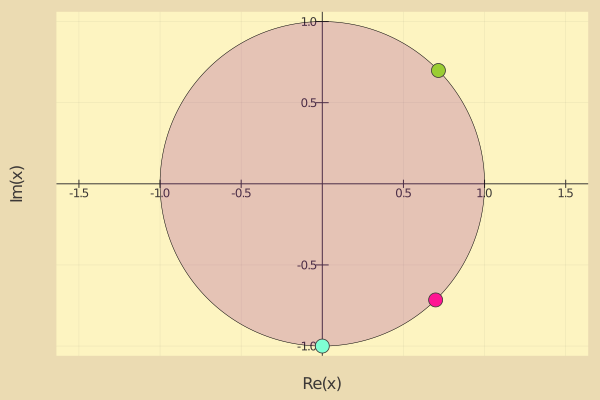

In [2]:
function complex_unit_circle()
    θ = LinRange(0, 2pi, 500)
    exp.(1im * θ)
end

function plot_complex_unit_circle(title="")
    plot(
        complex_unit_circle(),
        seriestype = [:shape],
        linecolor = :black,
        c = :darkmagenta,
        lw = 0.5,
        title = title,
        aspect_ratio = 1,
        legend = false,
        fillalpha = 0.2,
        framestyle=:origin,
    )
end

plt = plot_complex_unit_circle()

sr = 1024
freq = 2
n = 0:1024

# Let this be the first point in a signal x, x[0]
sig = exp.(1im * 2π * freq * n / sr)
# x0 = exp(1im * 0);

x0 = sig[64]
# k is the amount of time delay in the signal in points. As in, where was the signal k ticks ago,
# or in other words we're looking for x[n - k]
k = -128;

# Note that z is not a phasor, it's just a complex number that rotates another complex number around
# the unit circle, using magic. You can see that the position of z shows how much it's going to push
# or pull an initial point forward or backword in time when multiplied with point n in a signal.
# z and the input signal definitely must agree about the frequency.

# This can also be expressed as z = exp(1im * 2π * f / sr)^k, making z^-k a handy notation for time
# delay.
z = exp(1im * 2π * freq * k/ sr);


delayed_signal = x0 * z;

point = x0.re, x0.im;
z_point = z.re, z.im;
delayed_point = delayed_signal.re, delayed_signal.im;
scatter!(point, c = :yellowgreen, m = 8)
scatter!(delayed_point, c = :deeppink, m = 8)
scatter!(z_point, c = :aquamarine, m = 8)

$z$ itself is just a recipe for for creating a periodic sinusoidal signal with some frequency (and some damping factor,
which we'll explore soon), where every point in the signal is conveniently indexed by evaluating $z^{k}$.

$z$ can be thought of as a function which is a applied to two arguments, one for the damping factor, and another for
the frequency. Once you have a concrete instance of it, the value of $z$ will be a complex number, which is a recipe
for creating a signal by raising $z$ to the power of a series of $k$s

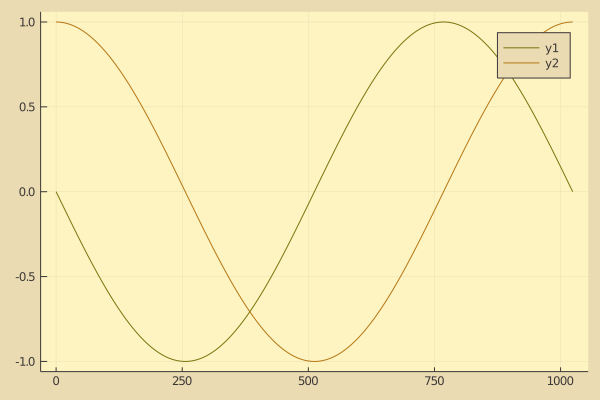

In [3]:
ts = 1 / 1024
z_func(damp, freq) = damp * exp(1im * 2π * freq * ts)

t = 0:1024

# We're not going to worry about the damping factor just yet, 
z_1 = z_func(1, 1)

sig = z_1.^(-t)

plot(t, map(x -> x.im, sig))
plot!(t, map(x -> x.re, sig))

The **$Z$ Transform** is very similar to the **Fourier Transform**. The Fourier transform is a function that takes a frequency argument, and builds a test complex sinusoid with that frequency and uses it to test the input signal. The test sinusoid is kinda built on rails.

The $Z$ Transform says, "bring your own damn complex number generator thing, that allows you to create a signal with any frequency you choose, and even some damping factor". If your provided $z$ has a damping factor of 1, there's no difference between the $z$ and Fourier transforms.

Remeber that convolution in the time domain is the same as multiplication in the frequency domain? This means that if you take the $z$ transform of an input ($X(z)$) and an impulse response ($H(z)$), your output $Y(z)$ will be $Y(z) = X(z) \cdot H(z)$

This seems to mean that the transfer function $H(z)$ is related to the impulse response. What's the relationship, and why is $H(z)$ more desired than $Y(z)$ for evaluation?

The value of the variable $z$ can be any complex number, and it can be thought of as a kernel for doing the $z$ transform on any sequence.

When $z$ is on the unit circle, it is a recipe for building a complex sinusoid with constant magnitude. Because $z$ is a constant value where the exponent is scaled by a provided frequency value, and because it is always raised to some power, 1 to start with, angle of $z$ indicates the frequency of the signal it will be used to generate. 

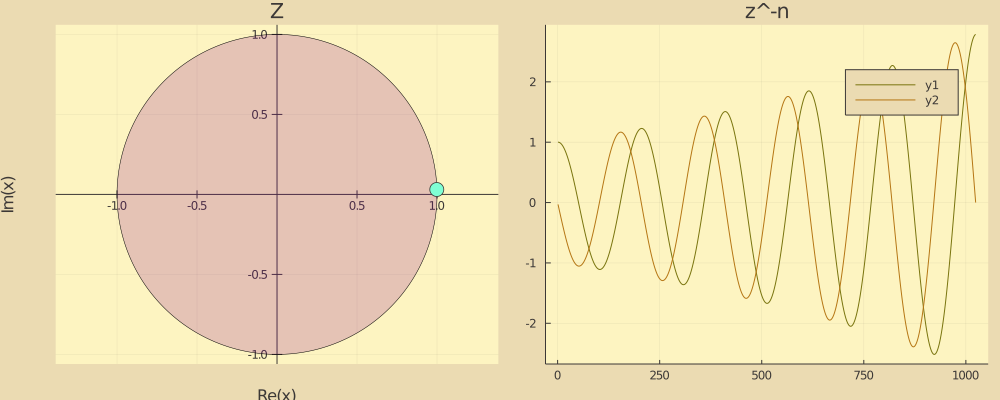

In [4]:
fs = 1024

k = 1:1024

# Create a value for z with a given frequency and damping factor
mk_z(A, f) = A * exp(1im * 2π * f / fs)

z0 = mk_z(0.999, 5)

sig = z0.^(-k)

plt = plot_complex_unit_circle("Z")
z0_point = z0.re, z0.im;
scatter!(z0_point, c = :aquamarine, m = 8)

p2 = plot(k, map(x -> x.re, sig), title="z^-n")
plot!(k, map(x -> x.im, sig))

plot(plt, p2, layout = 2, size=(1000, 400))

# Here we can see the value of a concrete instance of z, and the signal it gererates when raised to successive powers.

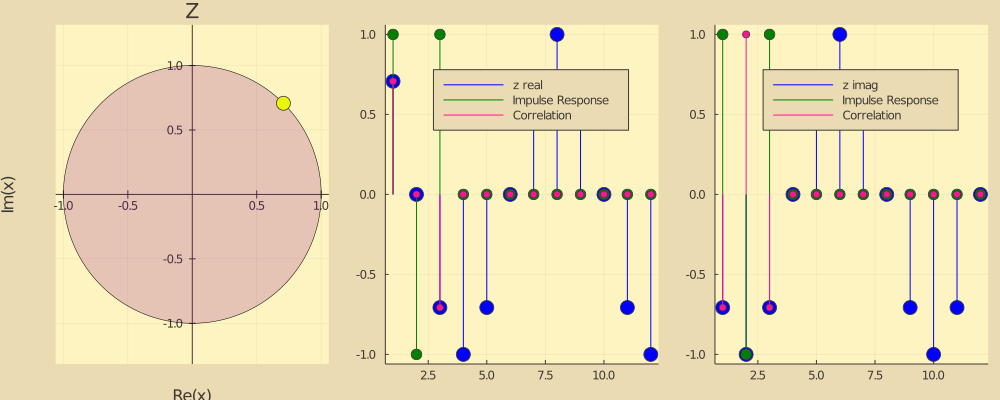

In [11]:
kernel = [1.0, -1.0, 1.0]
h = [kernel ; zeros(12 - length(kernel))]

# Z params
A = 1.0
freq = 128

k = 1:length(h)
    
z1 = mk_z(A, freq)   
z_seq = z1.^(-k)
    
correlation = z_seq .* h

# We'll use different colors to represent the magnitude for a given z. A zero will be totally
# the second color argument, and a high magnitude, will approach the first color value.
# This will help illustrate that there is a big ass pole at origin as well.
Mag = abs(sum(correlation))
color = weighted_color_mean(Mag * 0.2, colorant"teal", colorant"yellow")

# Plot z on the complex plane, with a color to indicate the magnitude of the dot product of z^(-k) and the 
# impulse response.
z_plot = plot_complex_unit_circle("Z")
plot!((z1.re, z1.im), c=color, m=8)

# Stem plot the z sequence (real and imag components), the impulse response (with added zeros for clarity),
# and the real part of the correlation
p_real = plot(k, map(x -> x.re, z_seq), label="z real", line=:stem, marker=:dot, m=8, c=:blue)
plot!(k, h, label="Impulse Response", line=:stem, c=:green, m=6)
plot!(k, map(x -> x.re, correlation), label="Correlation", line=:stem, marker=:dot, m=4, c=:deeppink)

p_imag = plot(k, map(x -> x.im, z_seq), label="z imag", line=:stem, marker=:dot, m=8, c=:blue)
plot!(k, h, label="Impulse Response", line=:stem, c=:green, m=6)
plot!(k, map(x -> x.im, correlation), label="Correlation", line=:stem, marker=:dot, m=4, c=:deeppink)

plot(z_plot, p_real, p_imag, layout=(1, 3), size=(1000, 400))


The Fourier transform of an impulse reponse is its frequency reponse, since convolution in the time domain is multiplication in the frequency domain, and you can imagine sending through test frequencies that all had a magnitude of 1.

In the $z$ domain (which is just the complex plane), points inside the unit circle are recipes for creating (via $z^{-n}$) signals that increase in amplitude forever. If an impulse reponse looks like some point inside the unit circle in the $z$ domain, both signals grow in amplitude forever and so will there correlation. There is no convergence, because the dot product with only grow with every sample included in it. Therefore the frequency response of the IR, at the frequency (and damping factor) represented by a given value for z is very high or theoretically infinite where such a "pole" exists. Since we really only care about frequencies on the unit circle, where no damping factor is present, a filter is most unstable if it has a pole very near the unit circle.

An impulse reponse is really just a signal, and nothing more. For filter design, we choose a signal whose frequency response properties are suitable for convolution with an arbitrary input signal. 

> For a first-order filter, why does changing the second coefficient move the zero on the horizontal axis?

Because a steady IR like $[1, 1]$ is identical to the $DC$ signal at $0Hz$, and $[1, -1]$ is identical to the $Nyquist$ frequency. At $[1, 0]$ you only have the input signal, and a trival zero at origin.

> What happens if I change the first coefficient?

That's equivalent to scaling the input signal, so it could magnify, diminish, or invert (in other words proportionally scale) the effect of the second or any following coefficients. This seems basically pointless, so for filter design you might as well normalize the first coefficient to $1$.